In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, RNN, Dense, Dropout

In [3]:
import wandb
from wandb.integration.keras import WandbCallback

wandb.login(key='e030007b097df00d9a751748294abc8440f932b1')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b044 (mm21b044-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Question 1

In [5]:
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None, names=['latin', 'native'])
    df = df.dropna()
    df['latin'] = df['latin'].astype(str)
    df['native'] = df['native'].astype(str)
    return df

def load_dakshina_dataset(language_code='hi', base_dir='/kaggle/input/dak-data/dakshina_dataset_v1.0'):
    path = os.path.join(base_dir, language_code, 'lexicons')
    return (
        load_data(os.path.join(path, f'{language_code}.translit.sampled.train.tsv')),
        load_data(os.path.join(path, f'{language_code}.translit.sampled.dev.tsv')),
        load_data(os.path.join(path, f'{language_code}.translit.sampled.test.tsv')),
    )

train_data, val_data, test_data = load_dakshina_dataset()

# ─── 1) Extract raw texts ─────────────────────────────────────────
input_texts  = train_data['latin'].tolist()
target_texts = ['\t' + t + '\n' for t in train_data['native'].tolist()]

val_input_texts  = val_data['latin'].tolist()
val_target_texts = ['\t' + t + '\n' for t in val_data['native'].tolist()]

input_tokenizer = Tokenizer(char_level=True, oov_token=None)
input_tokenizer.fit_on_texts(input_texts + val_input_texts)

target_tokenizer = Tokenizer(char_level=True, oov_token=None)
target_tokenizer.fit_on_texts(target_texts + val_target_texts)

# ─── 3) Convert texts → integer sequences + pad to max lengths ───
# Compute max lengths
max_in  = max(len(txt) for txt in input_texts + val_input_texts)
max_out = max(len(txt) for txt in target_texts + val_target_texts)

# Integer‑encode + pad
encoder_input_train = pad_sequences(
    input_tokenizer.texts_to_sequences(input_texts),
    maxlen=max_in,
    padding='post'
)
decoder_input_train = pad_sequences(
    target_tokenizer.texts_to_sequences(target_texts),
    maxlen=max_out,
    padding='post'
)
# decoder targets are the decoder inputs shifted left by one
decoder_target_train = np.array(decoder_input_train)[:, 1:]
decoder_input_train   = np.array(decoder_input_train)[:, :-1]

# Do the same for validation set
encoder_input_val = pad_sequences(
    input_tokenizer.texts_to_sequences(val_input_texts),
    maxlen=max_in,
    padding='post'
)
decoder_input_val = pad_sequences(
    target_tokenizer.texts_to_sequences(val_target_texts),
    maxlen=max_out,
    padding='post'
)
decoder_target_val = np.array(decoder_input_val)[:, 1:]
decoder_input_val   = np.array(decoder_input_val)[:, :-1]

# Make sure any previous wandb runs are finished
try:
    wandb.finish()
except:
    pass

# Initialize wandb with proper error handling
try:
    wandb.init(
        project="DA_seq2seq_transliteration",
        name="vanilla_lstm_run_q1",
        # Removed reinit=True to prevent connection issues
        config={
            "model_type": "vanilla",
            "cell_type": "LSTM",
            "embedding_dim": 64,
            "hidden_dim": 128,
            "dropout_rate": 0.2,
            "batch_size": 64,
            "epochs": 10,
            "input_vocab_size": len(input_tokenizer.word_index) + 1,
            "target_vocab_size": len(target_tokenizer.word_index) + 1,
            "max_input_length": max_in,
            "max_target_length": max_out,
            "optimizer": "adam",
            "loss": "sparse_categorical_crossentropy",
            "dataset": "dakshina_hi"
        }
    )
except Exception as e:
    print(f"Failed to initialize wandb: {e}")
    # Create a dummy wandb to avoid errors in the code
    class DummyWandb:
        def log(self, *args, **kwargs):
            pass
        def config(self, *args, **kwargs):
            return type('obj', (object,), {
                'embedding_dim': 64,
                'hidden_dim': 128,
                'get': lambda s, k, d: d
            })
    wandb = DummyWandb()

class VanillaSeq2Seq:
    def __init__(self,
                 input_vocab_size,
                 target_vocab_size,
                 embedding_dim,
                 hidden_dim,
                 cell_type='LSTM',
                 dropout_rate=0.2,
                 num_encoder_layers=1,
                 num_decoder_layers=1):
        self.input_vocab_size  = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.embedding_dim     = embedding_dim
        self.hidden_dim        = hidden_dim
        self.cell_type         = cell_type
        self.dropout_rate      = dropout_rate
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.model = self._build_model()

    def _rnn_layer(self, return_sequences, return_state):
        """Factory for one RNN/LSTM/GRU layer."""
        if self.cell_type == 'LSTM':
            return LSTM(self.hidden_dim,
                        return_sequences=return_sequences,
                        return_state=return_state)
        elif self.cell_type == 'GRU':
            return GRU(self.hidden_dim,
                       return_sequences=return_sequences,
                       return_state=return_state)
        else:
            return RNN(self.hidden_dim,
                       return_sequences=return_sequences,
                       return_state=return_state)

    def _build_model(self):
        encoder_inputs = Input(shape=(None,), name='encoder_input')
        x = Embedding(self.input_vocab_size, self.embedding_dim)(encoder_inputs)
        x = Dropout(self.dropout_rate)(x)

        # Stack encoder layers
        encoder_states = []
        for i in range(self.num_encoder_layers):
            # last encoder layer returns only state, earlier ones return sequences
            rs = (i < self.num_encoder_layers - 1)
            if self.cell_type == 'LSTM':
                x, state_h, state_c = LSTM(
                    self.hidden_dim,
                    return_sequences=rs,
                    return_state=True,
                    name=f'enc_lstm_{i}'
                )(x)
                encoder_states = [state_h, state_c]
            else:
                x, state_h = self._rnn_layer(
                    return_sequences=rs,
                    return_state=True
                )(x)
                encoder_states = [state_h]

        decoder_inputs = Input(shape=(None,), name='decoder_input')
        y = Embedding(self.target_vocab_size, self.embedding_dim)(decoder_inputs)
        y = Dropout(self.dropout_rate)(y)

        # Stack decoder layers
        for i in range(self.num_decoder_layers):
            rs = True  # decoder always returns sequences for all but we only care about final dense
            if self.cell_type == 'LSTM':
                # feed initial_state only to the first decoder layer
                init_st = encoder_states if i == 0 else None
                y, dh, dc = LSTM(
                    self.hidden_dim,
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y, initial_state=init_st) if init_st else LSTM(
                    self.hidden_dim,
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y)
            else:
                init_st = encoder_states if i == 0 else None
                y, dh = self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y, initial_state=init_st) if init_st else self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y)

        # Final projection
        outputs = Dense(self.target_vocab_size, activation='softmax')(y)
        return Model([encoder_inputs, decoder_inputs], outputs)

    def compile(self, optimizer='adam', loss='sparse_categorical_crossentropy'):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    def fit(self, train_data, val_data, batch_size=64, epochs=8, callbacks=None):
        return self.model.fit(
            [train_data['encoder_input'], train_data['decoder_input']],
            np.expand_dims(train_data['decoder_target'], -1),
            validation_data=(
                [val_data['encoder_input'], val_data['decoder_input']],
                np.expand_dims(val_data['decoder_target'], -1)
            ),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks
        )
        
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

model = VanillaSeq2Seq(
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    embedding_dim=64,
    hidden_dim=128,
    cell_type='LSTM',
    dropout_rate=0.2
)

model.compile()

# Modified wandb callback with error handling
try:
    wandb_callback = WandbCallback(
        log_model=False,           # no wandb artifact
        save_graph=False,          # don't try to render graph
        save_model=False           # ✅ disables all auto saving
    )
    callbacks = [wandb_callback]
except Exception as e:
    print(f"Failed to initialize WandbCallback: {e}")
    callbacks = []

# Use try-except for wandb config access
try:
    D = wandb.config.embedding_dim
    H = wandb.config.hidden_dim
    L_e = wandb.config.get("num_encoder_layers", 1)
    L_d = wandb.config.get("num_decoder_layers", 1)
except Exception as e:
    print(f"Failed to access wandb config: {e}")
    D = 64  # Default values
    H = 128
    L_e = 1
    L_d = 1

T_enc = encoder_input_train.shape[1]
T_dec = decoder_input_train.shape[1]

flops_per_step = 4 * (H * D + H * H)

# 4) Total ops over all layers & timesteps
total_enc_flops = L_e * T_enc * flops_per_step
total_dec_flops = L_d * T_dec * flops_per_step
total_flops = total_enc_flops + total_dec_flops

print(f"Approximate total multiplications (encoder + decoder): {total_flops:,}")

total_params = model.model.count_params()
print(f"Total trainable parameters: {total_params:,}")

model.model.summary()

history = model.fit(
    train_data={
        'encoder_input': encoder_input_train,
        'decoder_input': decoder_input_train,
        'decoder_target': decoder_target_train
    },
    val_data={
        'encoder_input': encoder_input_val,
        'decoder_input': decoder_input_val,
        'decoder_target': decoder_target_val
    },
    batch_size=64,
    epochs=8,
    callbacks=callbacks
)

# Log metrics to wandb with error handling
try:
    wandb.log({
        "total_flops": total_flops,
        "total_trainable_params": total_params
    })
    # Properly close the wandb run
    wandb.finish()
except Exception as e:
    print(f"Failed to log to wandb: {e}")

I0000 00:00:1747749727.720180      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747749727.720823      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Approximate total multiplications (encoder + decoder): 2,260,992
Total trainable parameters: 201,869


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 64)       │          1,728 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 64)       │            832 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, 64)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 64)       │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_lstm_0 (LSTM)         │ [(None, 128), (None,   │         98,816 │ dropout[0][0]          │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec_lstm_0 (LSTM)         │ [(None, None, 128),    │         98,816 │ dropout_1[0][0],       │
│                           │ (None, 128), (None,    │                │ enc_lstm_0[0][1],      │
│                           │ 128)]                  │                │ enc_lstm_0[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 13)       │          1,677 │ dec_lstm_0[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 201,869 (788.55 KB)

 Trainable params: 201,869 (788.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8


I0000 00:00:1747749734.614468     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


691/691 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7907 - loss: 0.6139 - val_accuracy: 0.8282 - val_loss: 0.3884
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8258 - loss: 0.4008 - val_accuracy: 0.8293 - val_loss: 0.3774
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8283 - loss: 0.3912 - val_accuracy: 0.8322 - val_loss: 0.3763
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8310 - loss: 0.3900 - val_accuracy: 0.8346 - val_loss: 0.3753
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8341 - loss: 0.3864 - val_accuracy: 0.8374 - val_loss: 0.3713
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8370 - loss: 0.3810 - val_accuracy: 0.8403 - val_loss: 0.3711
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8407 - loss: 0.3774 - val_accuracy: 0.8440 - val_loss: 0.3640
Epoch 8/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8410 - loss: 0.3755 - val_accuracy: 0.8440 - val_loss: 

accuracy,▁▃▄▅▆▇██
epoch,▁▂▃▄▅▆▇█
loss,█▃▂▂▂▂▁▁
total_flops,▁
total_trainable_params,▁
val_accuracy,▁▁▃▄▅▆██
val_loss,█▅▅▄▃▃▁▁
accuracy,0.84121
best_epoch,7
best_val_loss,0.36256
epoch,7


# Question 2

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
import os
import time
import matplotlib.pyplot as plt

In [7]:
# Load the Dakshina dataset (Hindi as an example)
# You can change 'hi' to the language of your choice
def load_dakshina_data(lang='hi'):
    base_path = f'/kaggle/input/dak-data/dakshina_dataset_v1.0/{lang}/lexicons/'
    
    # Load train, dev, test sets
    train_data = pd.read_csv(f'{base_path}{lang}.translit.sampled.train.tsv', sep='\t', 
                             header=None, names=['latin', 'native', 'class'])
    val_data = pd.read_csv(f'{base_path}{lang}.translit.sampled.dev.tsv', sep='\t', 
                           header=None, names=['latin', 'native', 'class'])
    test_data = pd.read_csv(f'{base_path}{lang}.translit.sampled.test.tsv', sep='\t', 
                            header=None, names=['latin', 'native', 'class'])

    # Drop any rows with missing values
    train_data = train_data.dropna().astype(str)
    val_data   = val_data.dropna().astype(str)
    test_data  = test_data.dropna().astype(str)

    return train_data, val_data, test_data

# Process data and create sequences
def process_data(train_data, val_data):
    # Extract texts
    input_texts = train_data['latin'].tolist()
    target_texts = ['\t' + t + '\n' for t in train_data['native'].tolist()]
    
    val_input_texts = val_data['latin'].tolist()
    val_target_texts = ['\t' + t + '\n' for t in val_data['native'].tolist()]
    
    # Build character-level tokenizers
    input_tokenizer = Tokenizer(char_level=True, oov_token=None)
    input_tokenizer.fit_on_texts(input_texts + val_input_texts)
    
    target_tokenizer = Tokenizer(char_level=True, oov_token=None)
    target_tokenizer.fit_on_texts(target_texts + val_target_texts)
    
    # Find max lengths
    max_in = max(len(txt) for txt in input_texts + val_input_texts)
    max_out = max(len(txt) for txt in target_texts + val_target_texts)
    
    # Convert to sequences and pad
    encoder_input_train = pad_sequences(
        input_tokenizer.texts_to_sequences(input_texts),
        maxlen=max_in,
        padding='post'
    )
    decoder_input_train = pad_sequences(
        target_tokenizer.texts_to_sequences(target_texts),
        maxlen=max_out,
        padding='post'
    )
    decoder_target_train = np.array(decoder_input_train)[:, 1:]
    decoder_input_train = np.array(decoder_input_train)[:, :-1]
    
    # Same for validation set
    encoder_input_val = pad_sequences(
        input_tokenizer.texts_to_sequences(val_input_texts),
        maxlen=max_in,
        padding='post'
    )
    decoder_input_val = pad_sequences(
        target_tokenizer.texts_to_sequences(val_target_texts),
        maxlen=max_out,
        padding='post'
    )
    decoder_target_val = np.array(decoder_input_val)[:, 1:]
    decoder_input_val = np.array(decoder_input_val)[:, :-1]
    
    return {
        'input_tokenizer': input_tokenizer,
        'target_tokenizer': target_tokenizer,
        'max_in': max_in,
        'max_out': max_out,
        'encoder_input_train': encoder_input_train,
        'decoder_input_train': decoder_input_train,
        'decoder_target_train': decoder_target_train,
        'encoder_input_val': encoder_input_val,
        'decoder_input_val': decoder_input_val,
        'decoder_target_val': decoder_target_val,
        'input_texts': input_texts,
        'target_texts': target_texts,
        'val_input_texts': val_input_texts,
        'val_target_texts': val_target_texts
    }

# Seq2Seq model with configurable parameters
class VanillaSeq2Seq:
    def __init__(self,
                 input_vocab_size,
                 target_vocab_size,
                 embedding_dim,
                 hidden_dim,
                 cell_type='LSTM',
                 dropout_rate=0.2,
                 num_encoder_layers=1,
                 num_decoder_layers=1):
        self.input_vocab_size = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.dropout_rate = dropout_rate
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.model = self._build_model()
        
    def _rnn_layer(self, return_sequences, return_state):
        """Factory for one RNN/LSTM/GRU layer."""
        if self.cell_type == 'LSTM':
            return LSTM(self.hidden_dim,
                        return_sequences=return_sequences,
                        return_state=return_state)
        elif self.cell_type == 'GRU':
            return GRU(self.hidden_dim,
                       return_sequences=return_sequences,
                       return_state=return_state)
        else:  # 'RNN'
            return SimpleRNN(self.hidden_dim,
                             return_sequences=return_sequences,
                             return_state=return_state)

    
    def _build_model(self):
        encoder_inputs = Input(shape=(None,), name='encoder_input')
        x = Embedding(self.input_vocab_size, self.embedding_dim)(encoder_inputs)
        x = Dropout(self.dropout_rate)(x)
        
        # Stack encoder layers
        encoder_states = []
        for i in range(self.num_encoder_layers):
            # last encoder layer returns only state, earlier ones return sequences
            rs = (i < self.num_encoder_layers - 1)
            if self.cell_type == 'LSTM':
                x, state_h, state_c = LSTM(
                    self.hidden_dim,
                    return_sequences=rs,
                    return_state=True,
                    name=f'enc_lstm_{i}'
                )(x)
                encoder_states = [state_h, state_c]
            else:
                x, state_h = self._rnn_layer(
                    return_sequences=rs,
                    return_state=True
                )(x)
                encoder_states = [state_h]
        
        decoder_inputs = Input(shape=(None,), name='decoder_input')
        y = Embedding(self.target_vocab_size, self.embedding_dim)(decoder_inputs)
        y = Dropout(self.dropout_rate)(y)
        
        # Stack decoder layers
        for i in range(self.num_decoder_layers):
            rs = True  # decoder always returns sequences
            if self.cell_type == 'LSTM':
                # feed initial_state only to the first decoder layer
                init_st = encoder_states if i == 0 else None
                y, dh, dc = LSTM(
                    self.hidden_dim, 
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y, initial_state=init_st) if init_st else LSTM(
                    self.hidden_dim,
                    return_sequences=True,
                    return_state=True,
                    name=f'dec_lstm_{i}'
                )(y)
            else:
                init_st = encoder_states if i == 0 else None
                y, dh = self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y, initial_state=init_st) if init_st else self._rnn_layer(
                    return_sequences=True,
                    return_state=True
                )(y)
        
        # Final projection
        outputs = Dense(self.target_vocab_size, activation='softmax')(y)
        return Model([encoder_inputs, decoder_inputs], outputs)
    
    def compile(self, optimizer='adam', loss='sparse_categorical_crossentropy'):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
    def fit(self, train_data, val_data, batch_size=64, epochs=8, callbacks=None):
        return self.model.fit(
            [train_data['encoder_input'], train_data['decoder_input']],
            np.expand_dims(train_data['decoder_target'], -1),
            validation_data=(
                [val_data['encoder_input'], val_data['decoder_input']],
                np.expand_dims(val_data['decoder_target'], -1)
            ),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks
        )

def run_wandb_sweep(processed_data):
    # Define sweep configuration
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'embedding_dim': {
                'values': [16, 32, 64, 128]
            },
            'hidden_dim': {
                'values': [32, 64, 128, 256]
            },
            'cell_type': {
                'values': ['RNN', 'GRU', 'LSTM']
            },
            'dropout_rate': {
                'values': [0.1, 0.2, 0.3]
            },
            'num_encoder_layers': {
                'values': [1, 2]
            },
            'num_decoder_layers': {
                'values': [1, 2]
            }
        }
    }
    
    # Initialize sweep
    sweep_id = wandb.sweep(sweep_config, project="DA_seq2seq_transliteration")
    
    # Define the training function
    def train_model():
        # Make sure we're in a clean wandb state
        try:
            wandb.finish()
        except:
            pass
        
        # Start a new wandb run
        run = wandb.init()
        
        # Access hyperparameters from wandb
        config = wandb.config
        
        # Create model with hyperparameters from wandb
        input_vocab_size = len(processed_data['input_tokenizer'].word_index) + 1
        target_vocab_size = len(processed_data['target_tokenizer'].word_index) + 1
        
        model = VanillaSeq2Seq(
            input_vocab_size=input_vocab_size,
            target_vocab_size=target_vocab_size,
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            cell_type=config.cell_type,
            dropout_rate=config.dropout_rate,
            num_encoder_layers=config.num_encoder_layers,
            num_decoder_layers=config.num_decoder_layers
        )
        
        model.compile()
        
        # Configure wandb callback
        wandb_callback = WandbCallback(
            log_model=False,
            save_graph=False,
            save_model=False
        )
        
        # Compute model complexity metrics
        D = config.embedding_dim
        H = config.hidden_dim
        L_e = config.num_encoder_layers
        L_d = config.num_decoder_layers
        T_enc = processed_data['encoder_input_train'].shape[1]
        T_dec = processed_data['decoder_input_train'].shape[1]
        
        flops_per_step = 4 * (H * D + H * H)
        total_enc_flops = L_e * T_enc * flops_per_step
        total_dec_flops = L_d * T_dec * flops_per_step
        total_flops = total_enc_flops + total_dec_flops
        
        total_params = model.model.count_params()
        
        print(f"Embedding dim: {D}, Hidden dim: {H}")
        print(f"Encoder layers: {L_e}, Decoder layers: {L_d}")
        print(f"Cell type: {config.cell_type}, Dropout: {config.dropout_rate}")
        print(f"Total parameters: {total_params:,}")
        print(f"Total FLOPs: {total_flops:,}")
        
        # Log model complexity metrics
        wandb.log({
            "total_flops": total_flops,
            "total_params": total_params
        })
        
        # Train the model
        start_time = time.time()
        
        history = model.fit(
            train_data={
                'encoder_input': processed_data['encoder_input_train'],
                'decoder_input': processed_data['decoder_input_train'],
                'decoder_target': processed_data['decoder_target_train']
            },
            val_data={
                'encoder_input': processed_data['encoder_input_val'],
                'decoder_input': processed_data['decoder_input_val'],
                'decoder_target': processed_data['decoder_target_val']
            },
            batch_size=64,
            epochs=8,
            callbacks=[wandb_callback]
        )
        
        training_time = time.time() - start_time
        
        # Log additional metrics
        wandb.log({
            "training_time": training_time,
            "final_train_accuracy": history.history['accuracy'][-1],
            "final_val_accuracy": history.history['val_accuracy'][-1]
        })
        
        # Clean up (important to avoid memory leaks)
        tf.keras.backend.clear_session()
        run.finish()
    
    # Run the sweep
    wandb.agent(sweep_id, train_model, count=7)  # Adjust count based on time constraints


In [6]:
# Main execution
if __name__ == "__main__":
    # Ensure TensorFlow doesn't reserve all GPU memory
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    
    # Load data
    try:
        train_data, val_data, test_data = load_dakshina_data(lang='hi')
        print(f"Data loaded successfully! Train size: {len(train_data)}")
        
        # Process data
        processed_data = process_data(train_data, val_data)
        print("Data processed successfully!")
        
        # Run sweep
        print("Starting hyperparameter sweep...")
        run_wandb_sweep(processed_data)
        
    except Exception as e:
        print(f"Error: {str(e)}")

Data loaded successfully! Train size: 44202
Data processed successfully!
Starting hyperparameter sweep...
Create sweep with ID: mpq5soqm
Sweep URL: https://wandb.ai/mm21b044-indian-institute-of-technology-madras/DA_seq2seq_transliteration/sweeps/mpq5soqm


wandb: Agent Starting Run: inksfj02 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Embedding dim: 64, Hidden dim: 256
Encoder layers: 2, Decoder layers: 1
Cell type: LSTM, Dropout: 0.3
Total parameters: 1,196,125
Total FLOPs: 19,333,120
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 143s 196ms/step - accuracy: 0.7037 - loss: 1.1084 - val_accuracy: 0.7615 - val_loss: 0.7974
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.7614 - loss: 0.7937 - val_accuracy: 0.8196 - val_loss: 0.5974
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 135s 196ms/step - accuracy: 0.8165 - loss: 0.5964 - val_accuracy: 0.8607 - val_loss: 0.4616
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 137s 198ms/step - accuracy: 0.8617 - loss: 0.4554 - val_accuracy: 0.9029 - val_loss: 0.3273
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 135s 196ms/step - accuracy: 0.8995 - loss: 0.3332 - val_accuracy: 0.9259 - val_loss: 0.2486
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 132s 191ms/step - accuracy: 0.9226 - loss: 0.2538 - val_accuracy: 0.9383 - val_loss: 0.2057
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 134s 193ms/step - acc

accuracy,▁▂▄▆▇▇██
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▅▃▂▂▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▃▅▆▇███
val_loss,█▆▄▃▂▁▁▁
accuracy,0.9442


wandb: Agent Starting Run: 0r31b8ft with config:
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.2
wandb: 	embedding_dim: 16
wandb: 	hidden_dim: 32
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 1


Embedding dim: 16, Hidden dim: 32
Encoder layers: 1, Decoder layers: 2
Cell type: GRU, Dropout: 0.2
Total parameters: 18,381
Total FLOPs: 374,784
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.6691 - loss: 1.3930 - val_accuracy: 0.7426 - val_loss: 0.8798
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7361 - loss: 0.9034 - val_accuracy: 0.7523 - val_loss: 0.8497
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7413 - loss: 0.8765 - val_accuracy: 0.7572 - val_loss: 0.8311
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7448 - loss: 0.8618 - val_accuracy: 0.7588 - val_loss: 0.8153
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7476 - loss: 0.8472 - val_accuracy: 0.7629 - val_loss: 0.7999
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7528 - loss: 0.8329 - val_accuracy: 0.7690 - val_loss: 0.7848
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.7580 - loss: 

accuracy,▁▅▅▆▆▇▇█
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▃▃▃▂▂▂▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▃▄▄▅▆▇█
val_loss,█▇▆▅▄▄▂▁
accuracy,0.76626


wandb: Agent Starting Run: hwigli45 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.2
wandb: 	embedding_dim: 16
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1


Embedding dim: 16, Hidden dim: 256
Encoder layers: 1, Decoder layers: 1
Cell type: LSTM, Dropout: 0.2
Total parameters: 568,045
Total FLOPs: 11,141,120
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.6936 - loss: 1.1958 - val_accuracy: 0.7601 - val_loss: 0.8091
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 77s 112ms/step - accuracy: 0.7529 - loss: 0.8280 - val_accuracy: 0.7808 - val_loss: 0.7201
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 79s 114ms/step - accuracy: 0.7740 - loss: 0.7476 - val_accuracy: 0.8014 - val_loss: 0.6486
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 79s 115ms/step - accuracy: 0.7905 - loss: 0.6829 - val_accuracy: 0.8204 - val_loss: 0.5936
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 95s 137ms/step - accuracy: 0.8057 - loss: 0.6309 - val_accuracy: 0.8310 - val_loss: 0.5477
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - accuracy: 0.8207 - loss: 0.5749 - val_accuracy: 0.8410 - val_loss: 0.5050
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 81s 117ms/step - accuracy: 0.

accuracy,▁▃▄▅▆▆▇█
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▅▄▃▂▂▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▂▃▅▅▆▇█
val_loss,█▇▅▄▄▃▂▁
accuracy,0.85587


wandb: Agent Starting Run: sydm6xg4 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 64
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


Embedding dim: 64, Hidden dim: 256
Encoder layers: 2, Decoder layers: 2
Cell type: LSTM, Dropout: 0.3
Total parameters: 1,721,437
Total FLOPs: 26,214,400
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 206s 284ms/step - accuracy: 0.6965 - loss: 1.1433 - val_accuracy: 0.7635 - val_loss: 0.7950
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 190s 275ms/step - accuracy: 0.7635 - loss: 0.7890 - val_accuracy: 0.8123 - val_loss: 0.6225
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 193s 279ms/step - accuracy: 0.8136 - loss: 0.6096 - val_accuracy: 0.8693 - val_loss: 0.4282
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 191s 276ms/step - accuracy: 0.8685 - loss: 0.4264 - val_accuracy: 0.9098 - val_loss: 0.2975
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 188s 273ms/step - accuracy: 0.9052 - loss: 0.3063 - val_accuracy: 0.9304 - val_loss: 0.2281
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 188s 272ms/step - accuracy: 0.9284 - loss: 0.2319 - val_accuracy: 0.9400 - val_loss: 0.1944
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 191s 276ms/step - acc

accuracy,▁▃▄▆▇▇██
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▄▃▂▂▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▃▅▇▇███
val_loss,█▆▄▂▂▁▁▁
accuracy,0.94798


wandb: Agent Starting Run: 1da0cgf0 with config:
wandb: 	cell_type: LSTM
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 128
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


Embedding dim: 128, Hidden dim: 256
Encoder layers: 2, Decoder layers: 2
Cell type: LSTM, Dropout: 0.3
Total parameters: 1,858,461
Total FLOPs: 31,457,280
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 211s 290ms/step - accuracy: 0.6999 - loss: 1.1278 - val_accuracy: 0.7640 - val_loss: 0.7907
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 195s 282ms/step - accuracy: 0.7704 - loss: 0.7635 - val_accuracy: 0.8331 - val_loss: 0.5421
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 195s 283ms/step - accuracy: 0.8366 - loss: 0.5290 - val_accuracy: 0.8907 - val_loss: 0.3595
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 195s 283ms/step - accuracy: 0.8925 - loss: 0.3483 - val_accuracy: 0.9280 - val_loss: 0.2395
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 206s 289ms/step - accuracy: 0.9258 - loss: 0.2404 - val_accuracy: 0.9406 - val_loss: 0.1942
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 199s 288ms/step - accuracy: 0.9410 - loss: 0.1892 - val_accuracy: 0.9475 - val_loss: 0.1709
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 197s 286ms/step - ac

accuracy,▁▃▅▆▇███
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▆▄▃▂▁▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▄▆▇████
val_loss,█▅▃▂▁▁▁▁
accuracy,0.95375


wandb: Agent Starting Run: vihxk2yq with config:
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.1
wandb: 	embedding_dim: 128
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


Embedding dim: 128, Hidden dim: 256
Encoder layers: 2, Decoder layers: 1
Cell type: GRU, Dropout: 0.1
Total parameters: 1,007,005
Total FLOPs: 23,199,744
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.7157 - loss: 1.0475 - val_accuracy: 0.7969 - val_loss: 0.6725
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 124s 179ms/step - accuracy: 0.8153 - loss: 0.6139 - val_accuracy: 0.8872 - val_loss: 0.3759
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 123s 178ms/step - accuracy: 0.8920 - loss: 0.3576 - val_accuracy: 0.9281 - val_loss: 0.2485
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - accuracy: 0.9271 - loss: 0.2398 - val_accuracy: 0.9403 - val_loss: 0.1994
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 122s 176ms/step - accuracy: 0.9407 - loss: 0.1928 - val_accuracy: 0.9415 - val_loss: 0.1880
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 123s 178ms/step - accuracy: 0.9468 - loss: 0.1675 - val_accuracy: 0.9477 - val_loss: 0.1733
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 124s 179ms/step - acc

accuracy,▁▄▆▇████
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▅▃▂▁▁▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▅▇█████
val_loss,█▄▂▂▁▁▁▁
accuracy,0.95386


wandb: Agent Starting Run: 6n1ssi28 with config:
wandb: 	cell_type: GRU
wandb: 	dropout_rate: 0.3
wandb: 	embedding_dim: 128
wandb: 	hidden_dim: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


Embedding dim: 128, Hidden dim: 256
Encoder layers: 2, Decoder layers: 1
Cell type: GRU, Dropout: 0.3
Total parameters: 1,007,005
Total FLOPs: 23,199,744
Epoch 1/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 141s 190ms/step - accuracy: 0.7152 - loss: 1.0636 - val_accuracy: 0.7932 - val_loss: 0.6926
Epoch 2/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 126s 183ms/step - accuracy: 0.8013 - loss: 0.6613 - val_accuracy: 0.8663 - val_loss: 0.4354
Epoch 3/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 127s 184ms/step - accuracy: 0.8725 - loss: 0.4221 - val_accuracy: 0.9152 - val_loss: 0.2891
Epoch 4/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 125s 181ms/step - accuracy: 0.9130 - loss: 0.2876 - val_accuracy: 0.9335 - val_loss: 0.2224
Epoch 5/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 122s 176ms/step - accuracy: 0.9320 - loss: 0.2232 - val_accuracy: 0.9418 - val_loss: 0.1931
Epoch 6/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - accuracy: 0.9407 - loss: 0.1891 - val_accuracy: 0.9459 - val_loss: 0.1762
Epoch 7/8
691/691 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - acc

accuracy,▁▄▆▇▇███
epoch,▁▂▃▄▅▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
loss,█▅▃▂▂▁▁▁
total_flops,▁
total_params,▁
training_time,▁
val_accuracy,▁▄▆▇████
val_loss,█▅▃▂▁▁▁▁
accuracy,0.94977


# Question 4

In [14]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks as keras_cb
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbCallback

# ─── A) Bring data & tokenizers back into scope ───────────────────
try:
    pi = processed_data
    input_tokenizer  = pi['input_tokenizer']
    target_tokenizer = pi['target_tokenizer']
    max_in, max_out = pi['max_in'], pi['max_out']
    encoder_input_train = pi['encoder_input_train']
    decoder_input_train = pi['decoder_input_train']
    decoder_target_train= pi['decoder_target_train']
    encoder_input_val   = pi['encoder_input_val']
    decoder_input_val   = pi['decoder_input_val']
    decoder_target_val  = pi['decoder_target_val']
    print("✅ Data and tokenizers loaded from cache.")
except NameError:
    train_data, val_data, test_data = load_dakshina_data(lang='hi')
    pi = process_data(train_data, val_data)
    input_tokenizer  = pi['input_tokenizer']
    target_tokenizer = pi['target_tokenizer']
    max_in, max_out = pi['max_in'], pi['max_out']
    encoder_input_train = pi['encoder_input_train']
    decoder_input_train = pi['decoder_input_train']
    decoder_target_train= pi['decoder_target_train']
    encoder_input_val   = pi['encoder_input_val']
    decoder_input_val   = pi['decoder_input_val']
    decoder_target_val  = pi['decoder_target_val']
    print("✅ Data processed and tokenizers created.")
print("✅ Step A complete")

# ─── B) Fetch best hyperparams ─────────────────────────────
api    = wandb.Api()
ENTITY = "mm21b044-indian-institute-of-technology-madras"
PROJ   = "DA_seq2seq_transliteration"

print("🔍 Fetching wandb runs...")
all_runs   = api.runs(f"{ENTITY}/{PROJ}")
valid_runs = [r for r in all_runs if 'final_val_accuracy' in r.summary]
best_run   = max(valid_runs, key=lambda r: r.summary['final_val_accuracy'])
best_cfg   = best_run.config

print(f"✅ Best run: {best_run.id} with val_accuracy={best_run.summary['final_val_accuracy']:.4f}")
print("Best sweep config:", best_cfg)

inp_vocab = len(input_tokenizer.word_index) + 1
tgt_vocab = len(target_tokenizer.word_index) + 1

BEST_HP = {
    'input_vocab_size':   inp_vocab,
    'target_vocab_size':  tgt_vocab,
    'embedding_dim':      best_cfg['embedding_dim'],
    'hidden_dim':         best_cfg['hidden_dim'],
    'cell_type':          best_cfg['cell_type'],
    'dropout_rate':       best_cfg['dropout_rate'],
    'num_encoder_layers': best_cfg.get('num_encoder_layers', 1),
    'num_decoder_layers': best_cfg.get('num_decoder_layers', 1)
}
print("✅ Step B complete")

# ─── C) Rebuild model ─────────────────────────────────────────────
print("🔧 Rebuilding model...")
model = VanillaSeq2Seq(**BEST_HP)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
print("✅ Model built and compiled.")

# ─── D) Prepare for retraining ───────────────────────────────────
y_train = np.expand_dims(decoder_target_train, -1)
y_val   = np.expand_dims(decoder_target_val, -1)

wandb.init(project=PROJ, name="q4_retrain_best_model", reinit=True)
wandb.config.update(BEST_HP, allow_val_change=True)

checkpoint_path = "/kaggle/working/q4_best_model.weights.h5"
cb = [
    keras_cb.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss'
    ),
    WandbCallback(
        save_model=False,
        log_weights=True,
        save_graph=False
    )
]
print("✅ Step D complete. Beginning training...")

# ─── E) Retrain ───────────────────────────────────────────────────
history = model.model.fit(
    [encoder_input_train, decoder_input_train],
    y_train,
    batch_size=wandb.config.get('batch_size', 64),
    epochs=10,
    validation_data=([encoder_input_val, decoder_input_val], y_val),
    callbacks=cb,
    verbose=1
)
print("✅ Training complete")

wandb.finish()
print("✅ wandb finished")

# ─── F) Load weights and prepare test ─────────────────────────────
model.model.load_weights(checkpoint_path)
print("✅ Weights loaded")

✅ Data processed and tokenizers created.
✅ Step A complete
🔍 Fetching wandb runs...
✅ Best run: s35s9ajw with val_accuracy=0.9523
Best sweep config: {'cell_type': 'LSTM', 'hidden_dim': 256, 'dropout_rate': 0.1, 'embedding_dim': 128, 'num_decoder_layers': 1, 'num_encoder_layers': 2}
✅ Step B complete
🔧 Rebuilding model...
✅ Model built and compiled.


✅ Step D complete. Beginning training...
Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7129 - loss: 1.0550 - val_accuracy: 0.7994 - val_loss: 0.6679
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8086 - loss: 0.6327 - val_accuracy: 0.8680 - val_loss: 0.4357
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8765 - loss: 0.4036 - val_accuracy: 0.9099 - val_loss: 0.2952
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9195 - loss: 0.2655 - val_accuracy: 0.9378 - val_loss: 0.2096
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9388 - loss: 0.2000 - val_accuracy: 0.9453 - val_loss: 0.1796
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9477 - loss: 0.1666 - val_accuracy: 0.9488 - val_loss: 0.1638
Epoch 7/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9526 - loss: 0.1477 - val_accuracy: 0.9519 - val_loss: 0.1548
Epoch 8/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - 

accuracy,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇██████
val_loss,█▅▃▂▁▁▁▁▁▁
accuracy,0.95989
best_epoch,9
best_val_loss,0.14247
epoch,9
loss,0.11669
val_accuracy,0.95404


✅ wandb finished
✅ Weights loaded


🧠 Starting decoding...


Decoding examples: 100%|██████████| 4502/4502 [45:57<00:00,  1.63it/s] 


✅ Decoding done
✅ Final test exact-match accuracy: 3.5318%


test_accuracy,▁
test_accuracy,0.03532


✅ Test accuracy logged to wandb
✅ Saved predictions to /kaggle/working/predictions_vanilla


/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3273880890.py:38: UserWarning: Gly

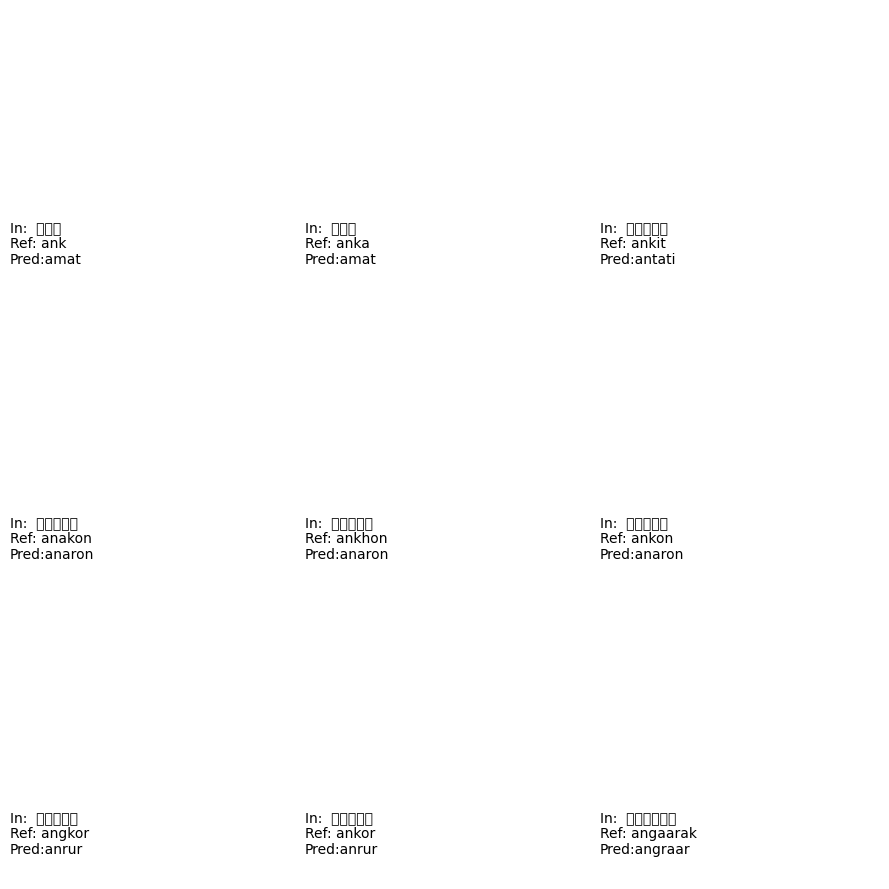

✅ Plot displayed


In [13]:
test_texts = test_data['latin'].astype(str).tolist()
true_texts = test_data['native'].astype(str).tolist()

enc_test = pad_sequences(
    input_tokenizer.texts_to_sequences(test_texts),
    maxlen=max_in, padding='post'
)
start_idx = target_tokenizer.texts_to_sequences(['\t'])[0][0]
index_to_char = {i: ch for ch, i in target_tokenizer.word_index.items()}
index_to_char[0] = ''

def decode(seq):
    seq = seq[np.newaxis]
    dec_input = np.array([[start_idx]])
    out = ''
    for _ in range(max_out):
        preds = model.model.predict([seq, dec_input], verbose=0)
        nxt = np.argmax(preds[0, -1, :])
        if nxt==0 or index_to_char[nxt]=='\n': break
        out += index_to_char[nxt]
        dec_input = np.concatenate([dec_input, [[nxt]]], axis=1)
    return out
print("🧠 Starting decoding...")
preds, corr = [], 0

for i, s in enumerate(tqdm(enc_test, desc="Decoding examples")):
    p = decode(s)
    preds.append(p)
    if p == true_texts[i]:
        corr += 1

print("✅ Decoding done")

✅ Final test exact-match accuracy: 3.5318%


test_accuracy,▁
test_accuracy,0.03532


✅ Test accuracy logged to wandb


Latin,Reference,Prediction
अंक,ank,amat
अंक,anka,amat
अंकित,ankit,antati
अंकों,anakon,anaron
अंकों,ankhon,anaron
अंकों,ankon,anaron
अंकोर,angkor,anrur
अंकोर,ankor,anrur
अंगारक,angaarak,angraar


/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/3018021838.py:30: UserWarning: Gly

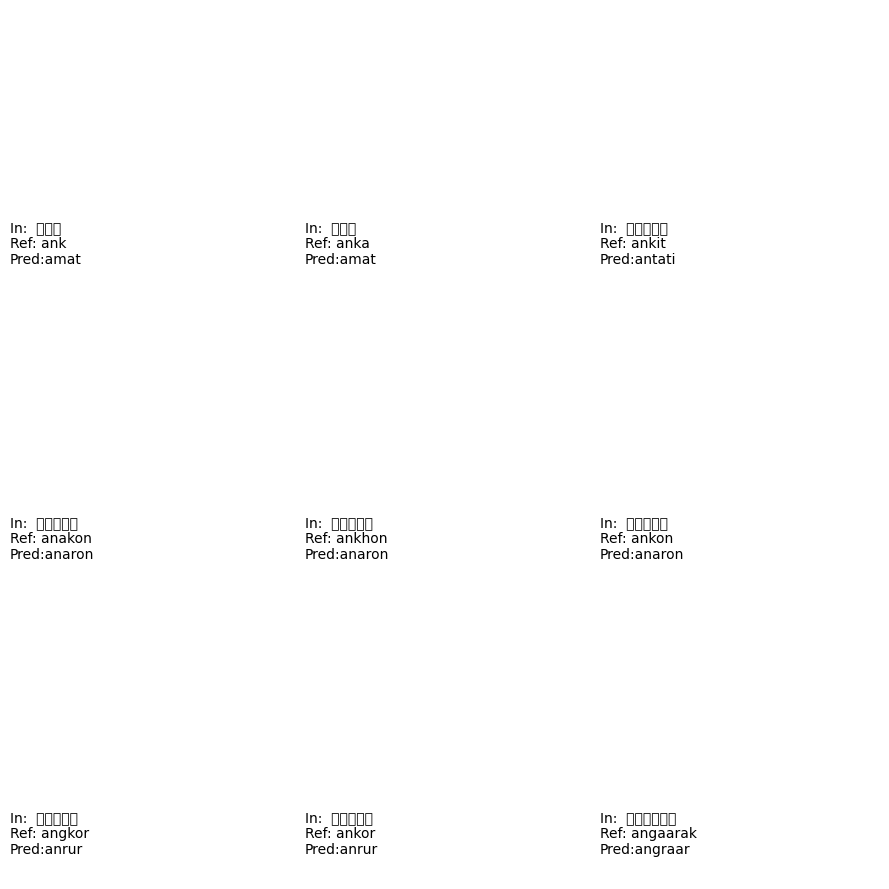

✅ Plot displayed


In [16]:
test_acc = corr / len(enc_test)
print(f"✅ Final test exact-match accuracy: {test_acc:.4%}")

# ─── G) Log test result ───────────────────────────────────────────
wandb.init(project=PROJ, name="q4_test_eval", reinit=True)
wandb.log({"test_accuracy": test_acc})
wandb.finish()
print("✅ Test accuracy logged to wandb")

# ─── H) Save & display predictions ───────────────────────────────
out_dir = "/kaggle/working/predictions_vanilla"
os.makedirs(out_dir, exist_ok=True)
import pandas as pd
from IPython.display import HTML, display

df = pd.DataFrame({
    "Latin":      test_texts[:9],
    "Reference":  true_texts[:9],
    "Prediction": preds[:9]
})

# Show as HTML table
display(HTML(df.to_html(index=False)))

fig, axes = plt.subplots(3,3,figsize=(9,9))
for ax, idx in zip(axes.flatten(), range(9)):
    txt = f"In:  {test_texts[idx]}\nRef: {true_texts[idx]}\nPred:{preds[idx]}"
    ax.text(0,0.1, txt, wrap=True)
    ax.axis('off')
plt.tight_layout()
plt.show()
print("✅ Plot displayed")

# Question 5

# Question 6

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# ─── A) Build sub‑models to extract encoder & decoder hidden states ─────────
# Assume `model` is your trained AttentionSeq2Seq or VanillaSeq2Seq.model
# and that its layers are named 'enc_lstm_0', 'dec_lstm_step' (or equivalent).

# 1) Encoder model: maps encoder inputs → all hidden states
enc_input  = model.input[0]  # encoder_input
enc_layer  = model.get_layer('enc_lstm_0')  # first encoder LSTM
enc_outputs, enc_h, enc_c = enc_layer.output, *enc_layer.states
encoder_model = Model(enc_input, enc_outputs)  

# 2) Decoder model: at each step, map [prev token, prev state] → [output, new state]
#    We reuse the same LSTM cell for each time‑step.
dec_input_token = model.input[1]  # decoder_input (full sequence)
# We will feed one time‑step at a time, so create placeholders:
dec_state_h = tf.keras.Input(shape=(H,), name='dec_state_h')
dec_state_c = tf.keras.Input(shape=(H,), name='dec_state_c')
dec_embed   = model.get_layer('embedding_1')(dec_input_token)  # your decoder Embedding
dec_lstm    = model.get_layer('dec_lstm_step')  
# slice out only the last time‑step from dec_embed:
last_token = dec_embed[:, -1:, :]  # shape (batch, 1, emb)
dec_out, new_h, new_c = dec_lstm(last_token, initial_state=[dec_state_h, dec_state_c])
decoder_model = Model(
    [dec_input_token, dec_state_h, dec_state_c],
    [dec_out, new_h, new_c]
)

# ─── B) Run through test set, collect states ────────────────────────────────
# Prepare test inputs as before
enc_test = encoder_input_test  # shape (N, T_enc)
dec_start = np.full((len(enc_test), 1), start_token_idx)

# 1) Get encoder hidden states for all examples
enc_all_states = encoder_model.predict(enc_test, batch_size=64)  
# shape (N, T_enc, H)

# 2) For each decoder step i, collect decoder hidden state across examples
max_steps = max_out - 1
dec_states = np.zeros((len(enc_test), max_steps, H))

# Initial decoder states = zero or encoder final states?
# Here we initialize from zeros; adjust if you used encoder states to init decoder.
state_h = np.zeros((len(enc_test), H))
state_c = np.zeros((len(enc_test), H))

# Step through decoder
for t in range(max_steps):
    # feed dec_start for first step, then zeros (we just want states)
    inp = dec_start if t == 0 else np.zeros_like(dec_start)
    out, state_h, state_c = decoder_model.predict([inp, state_h, state_c],
                                                 batch_size=64)
    dec_states[:, t, :] = state_h
    # next inp token ignored because we just care about states

# ─── C) Compute connectivity (correlation) matrices ────────────────────────
# For each decoder step t and each encoder time-step s, compute Pearson corr across batch
conn = np.zeros((max_steps, max_in))  # connectivity map

for t in range(max_steps):
    for s in range(max_in):
        # correlation across N examples between enc_all_states[:,s,:] and dec_states[:,t,:]
        # we compute mean over hidden dims:
        num = np.mean((enc_all_states[:, s, :] - enc_all_states[:, s, :].mean(axis=0)) *
                      (dec_states[:, t, :] - dec_states[:, t, :].mean(axis=0)), axis=1)
        den = np.std(enc_all_states[:, s, :], axis=1) * np.std(dec_states[:, t, :], axis=1) + 1e-8
        corr = np.mean(num/den)
        conn[t, s] = corr

# ─── D) Plot first 9 decoder‑step connectivity heatmaps ────────────────────
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for idx, ax in enumerate(axes.flatten()):
    if idx >= max_steps: break
    im = ax.imshow(conn[idx], aspect='auto', cmap='viridis')
    ax.set_title(f"Decoder Step {idx+1}")
    ax.set_xlabel("Encoder time‑step")
    ax.set_ylabel("Correlation")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.suptitle("Connectivity: which input positions relate to each output step")  
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()